<a href="https://colab.research.google.com/github/Sankytanky100/Data_Science-Projects/blob/main/Farm_Yield_Using_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Evaluating the Impact of Cover Crops on Farm Yield Using Propensity Score Weighting and Regression Analysis**

In [1]:
!pip install rpy2


In [2]:
!apt-get install -y r-base

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
%load_ext rpy2.ipython



In [4]:
%%R
install.packages("cobalt")
library(cobalt)


(as ‘lib’ is unspecified)



















	‘/tmp/RtmpbDXCFp/downloaded_packages’




In [7]:
%%R
install.packages("WeightIt")
library(WeightIt)
install.packages("lmtest")
library(lmtest)
install.packages("sandwich")
library(sandwich)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpbDXCFp/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpbDXCFp/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpbDXCFp/downloaded_packages’



In [9]:
from google.colab import files
uploaded = files.upload()  # Select the "farms.csv" file to upload


Saving farms.csv to farms (1).csv


In [13]:
%%R
# Task 1: Load file as dataframe
farm_df <- read.csv("farms.csv")

In [14]:
%%R
# Task 2: Inspect dataframe
head(farm_df)


  total_yield cover_10 region total_avg age_avg experience_avg insurance_avg
1    61.33234        0  South     0.305    57.2           21.6     0.2543968
2    47.47099        1  South     0.208    61.2           24.9     0.6386207
3    46.27485        0  South     0.307    61.0           24.5     0.4223478
4    81.77405        0  South     0.254    58.8           23.9     1.0557846
5    81.04827        0  South     0.117    58.0           23.9     0.2556000
6    58.26087        0  South     0.292    62.5           23.6     0.6138043
  easement_p conservation_till_avg fertilizer_per_area
1  1.8867925                   145            20.26741
2  1.5439430                   553            74.62687
3  0.8032129                    63            15.08367
4  1.1844332                   391            60.03353
5  0.5053341                    27            22.93760
6  2.3454158                   579            25.26148


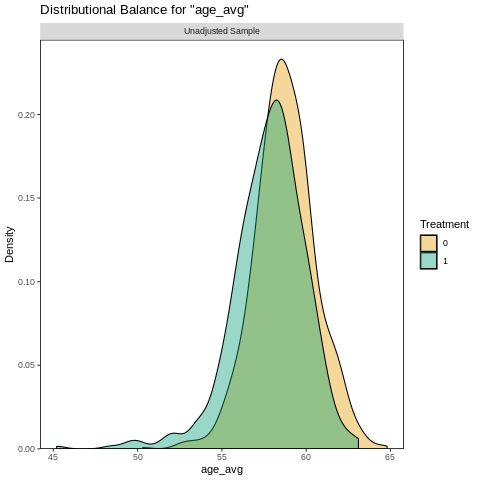

In [15]:
%%R
# Task 3: Balance plot for the average age
library(cobalt)
bal.plot(
  x = cover_10 ~ age_avg, #formula
  data = farm_df, #dataset
  var.name = "age_avg", #variable
  colors = c("#E69F00", "#009E73") #set fill colors
)


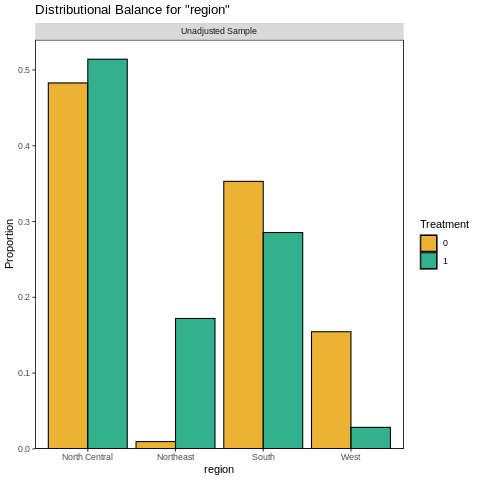

In [18]:
%%R
# Balance plot for geographic region
bal.plot(
  x = cover_10 ~ region, # formula
  data = farm_df,        # dataset
  var.name = "region",   # variable
  colors = c("#E69F00", "#009E73") # set fill colors
)

In [17]:
%%R
# Balance table to show SMD and variance ratio between groups
bal.tab(
  cover_10 ~ region + total_avg + age_avg + experience_avg + insurance_avg + easement_p + conservation_till_avg + fertilizer_per_area,
  data = farm_df,         # dataset
  binary = "std",         # SMD for binary
  disp.v.ratio = TRUE     # show variance ratios
)


Note: `s.d.denom` not specified; assuming "pooled".
Balance Measures
                         Type Diff.Un V.Ratio.Un
region_North Central   Binary  0.0627          .
region_Northeast       Binary  0.5896          .
region_South           Binary -0.1454          .
region_West            Binary -0.4488          .
total_avg             Contin. -0.4775     0.2499
age_avg               Contin. -0.4668     1.4521
experience_avg        Contin.  0.1226     0.7960
insurance_avg         Contin. -0.4963     0.4423
easement_p            Contin.  0.2982     1.1288
conservation_till_avg Contin. -0.3670     0.6057
fertilizer_per_area   Contin.  0.6299     1.5627

Sample sizes
    Control Treated
All    1048     529


In [19]:
%%R
# Calculate IPTW weights with initial propensity score model
farm_iptw <- weightit(
  cover_10 ~ region + total_avg + insurance_avg + fertilizer_per_area,
  data = farm_df,         # dataset
  method = "ps",          # use IPTW
  estimand = "ATE"        # IPTW formulas for the ATE
)


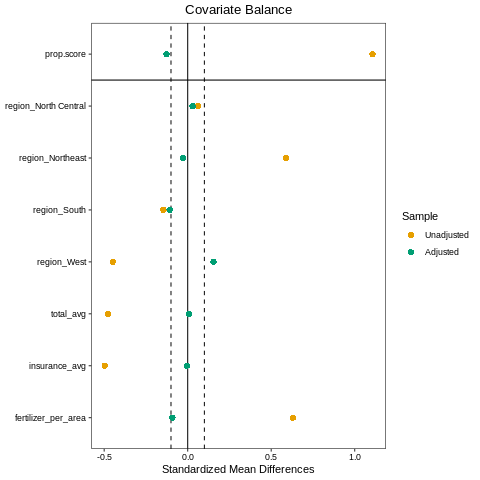

In [20]:
%%R
# Love plot with threshold lines to show SMD balance before and after weighting
love.plot(
  farm_iptw,              # weightit model
  binary = "std",         # use SMD for binary
  thresholds = c(m = 0.1), # guidelines
  colors = c("#E69F00", "#009E73") # set fill colors
)


In [21]:
%%R
# Re-calculate IPTW weights with updated propensity score model
farm_iptw2 <- weightit(
  cover_10 ~ region + total_avg + insurance_avg + age_avg + experience_avg + easement_p + conservation_till_avg,
  data = farm_df,         # dataset
  method = "ps",          # IPTW weights
  estimand = "ATE"        # IPTW for ATE
)


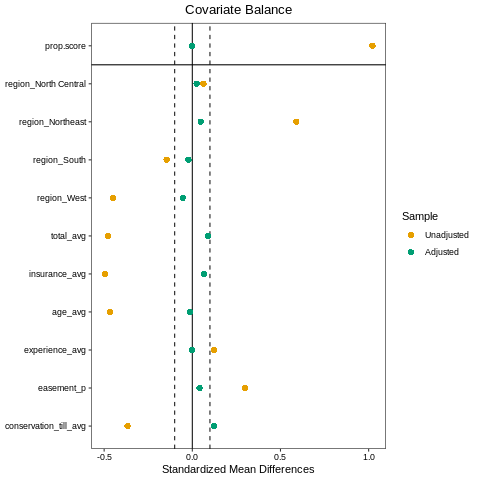

In [22]:
%%R
# Plot Love plot of SMDs with threshold lines to show balance before and after IPTW procedure
love.plot(
  farm_iptw2,             # weightit model
  binary = "std",         # use SMD for binary
  thresholds = c(m = 0.1), # guidelines
  colors = c("#E69F00", "#009E73") # set fill colors
)


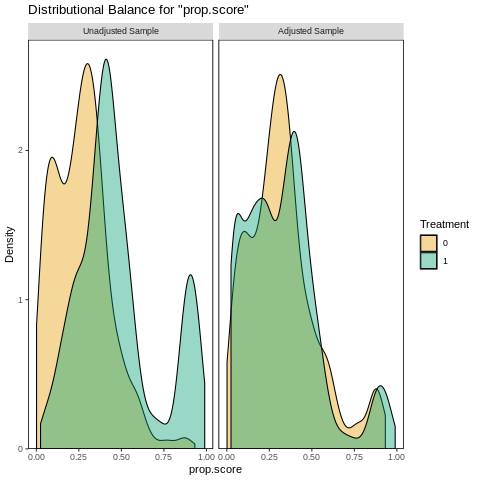

In [23]:
%%R
# Balance plot of propensity scores before and after weighting
bal.plot(
  x = farm_iptw2,         # model
  var.name = "prop.score", # propensity scores
  which = "both",         # before and after
  colors = c("#E69F00", "#009E73") # set fill colors
)


In [24]:
%%R
# Fit outcome regression model
yield_mod <- glm(
  formula = total_yield ~ cover_10 + region + total_avg + insurance_avg + age_avg + experience_avg + insurance_avg + easement_p + conservation_till_avg,
  data = farm_df,         # dataset
  weights = farm_iptw2$weights # IPTW weights
)


In [25]:
%%R

# Estimate regression coefficients for weighted outcome model with robust standard errors
coeftest(
  yield_mod,              # outcome model
  vcov. = vcovHC          # robust standard errors
)



z test of coefficients:

                         Estimate  Std. Error z value  Pr(>|z|)    
(Intercept)           111.0182307  15.4101202  7.2042 5.837e-13 ***
cover_10                3.5768404   1.0373046  3.4482 0.0005643 ***
regionNortheast        -7.8566450   2.4221267 -3.2437 0.0011799 ** 
regionSouth            -3.6146891   1.4750675 -2.4505 0.0142648 *  
regionWest             18.5398103   2.9171803  6.3554 2.079e-10 ***
total_avg             -18.1552947   2.1255363 -8.5415 < 2.2e-16 ***
insurance_avg           6.2900784   2.2013023  2.8574 0.0042708 ** 
age_avg                -1.7556714   0.2890145 -6.0747 1.242e-09 ***
experience_avg          2.1238056   0.3191488  6.6546 2.841e-11 ***
easement_p              0.2464213   0.1659482  1.4849 0.1375627    
conservation_till_avg  -0.0048407   0.0016546 -2.9256 0.0034379 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [27]:
## Results Interpretation:
Our estimate of the ATE is about 3.58. We estimate that when counties have at least 10% of farms with cover crops, the average total yield of wheat increases by about 3.58 bushels per acre.


SyntaxError: invalid syntax (<ipython-input-27-c0545c03b996>, line 2)